# Investigating factors of WA highway crashes
### Yidan Hu, Yuanjie Tu, Shuyi Yin, Shujun Zhou (Group 5)
#### CET 521 Inferential Data Analysis for Engineers

In [1]:
from IPython.display import display, HTML

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

## set-ups

### module

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import copy
plt.rc('text', usetex=True)

import warnings
warnings.filterwarnings('ignore')

### functions

In [4]:
def detect_files(directory, keyword):
    """
    detect files in specified directory with specified keyword

    input
    -----
    directory : string
        dir to search

    keyword : string
        keyword to look for

    output
    -----
    sorted list of file names

    test
    -----
        (1) if output has larger than length;
    """

    file_list = []
    for file in os.listdir(directory):
        if not (keyword is None):
            if keyword in file:
                file_list.append(file)
        else:
            file_list.append(file)
    
    return sorted(file_list)

def read_files(directory, keyword):
    """
    read files with specified keyword

    input
    -----
    directory : string
        directory to read files from

    keyword : string
        keyword to search for

    output
    -----
    output_dic : dic
        dictionary of datasets

    test
    -----
        (1) output_dic should have length 5, for 2013 - 2017;
        (2) keyword should not be empty;
    """
    output_dic = {}
    file_list = detect_files(directory, keyword)
    for yr in range(2013, 2018):
        output_dic[yr] = pd.read_csv(os.path.join(directory, file_list[yr-2013]))
    return output_dic

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)

def two_scales(ax1, time, data1, data2, data3, c1, c2, c3):
    ax2 = ax1.twinx()
    p1 = ax1.bar(time, data1, width=0.5, color=c1)
    p2 = ax1.bar(time, data2, width=0.5, bottom=data1, color=c2)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Num. of cases')
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    p3 = ax2.plot(time, data3, color=c3, linewidth=3)
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    color_y_axis(ax2, 'b')
    ax2.annotate("", xy=(2017.4, data3[-1]*0.98), xytext=(2017, data3[-1]*0.98),
                 arrowprops=dict(width=1, headwidth=8, headlength=8))
    # ax2.set_ylabel('Fatal')
    return ax1, ax2

def two_scales_with_legend(ax1, time, data1, data2, data3, c1, c2, c3):
    ax2 = ax1.twinx()
    p1 = ax1.bar(time, data1, width=0.5, color=c1, label='INJ')
    p2 = ax1.bar(time, data2, width=0.5, bottom=data1, color=c2, label='PDO')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Num. of cases')
    ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    p3 = ax2.plot(time, data3, color=c3, linewidth=3, label='FAT')
    ax2.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    color_y_axis(ax2, 'b')
    ax2.annotate("", xy=(2017.4, data3[-1]*0.98), xytext=(2017, data3[-1]*0.98),
                 arrowprops=dict(width=1, headwidth=8, headlength=8))
    # ax2.set_ylabel('Fatal')
    return ax1, ax2


## The problem

### What factors are associated with single vehicle accidents?
+ Why and how are people getting themselves into trouble?

## Exploratory analysis
[HSIS data](https://www.hsisinfo.org/index.cfm)

$$e^x = \sum_{k=0}^{\infty} \frac{x^k}{k!}$$

<table>
    <tr>
        <td>
\begin{eqnarray}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\end{eqnarray}
        </td>
        <td>
\begin{eqnarray}
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0
\end{eqnarray}
        </td>
    </tr>
</table>

Colons can be used to align columns.

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned | 1600 |
| col 2 is      | centered      |   12 |
| zebra stripes | are neat      |    1 |

There must be at least 3 dashes separating each header cell.
The outer pipes (|) are optional, and you don't need to make the 
raw Markdown line up prettily. You can also use inline Markdown.

Markdown | Less | Pretty
--- | --- | ---
*Still* | `renders` | **nicely**
1 | 2 | 3

In [5]:
crash = read_files(".././hsis-csv", 'acc')

### Crash type

In [6]:

combine_map = {
    1:11,
    2:12,
    3:13,
    4:14,
    5:15,
    6:16,
    7:17,

    # other multi 29
    27:29,
    28:29,
    
    71:77,# Peds and cyclist
    72:77,
    73:77,
    74:77,
    75:77,
    76:77,
    
    # single vehicle 99
    32:99,
    33:99,
    34:99,
    35:99,
    40:99,
    41:99,
    50:99,
    54:99,
    60:99,
    61:99,
    62:99,
    88:99,
    98:99
}

In [7]:
acc_by_type = {}
for year in range(2013, 2018):
    df = crash[year]
    acc_by_type[year] = df.ACCTYPE.replace(combine_map).value_counts().sort_index().to_frame()
    acc_by_type[year].columns = ['cnt']
    df = df[['ACCTYPE', 'REPORT']]
    df.ACCTYPE = df.ACCTYPE.replace(combine_map)
    acc_by_type[year] = acc_by_type[year].merge(
        df.groupby(['ACCTYPE', 'REPORT']).size().unstack().fillna(0).astype(int),
        left_index=True, right_index=True)
    columns = ['cnt', 'PDO', 'INJ', 'FAT']
    acc_by_type[year].columns = columns

We group the **accident types** (**ACCTYPE**) into:
+ Multi-vehicle;
    - Struck Head On;
    - Struck Left Side;
    - Struck Right Side;
    - Sideswiped Left Side;
    - Sideswiped Right Side;
    - Struck Rear End;
    - Struck Front End;
    - Other Multi;
+ Peds & Cyclists related;
+ Single-vehicle;

In [8]:
acc_type_list = [
    r'Struck Head On', r'Struck Left Side', r'Struck Right Side', 
    r'Sideswiped Left Side', r'Sideswiped Right Side',
    r'Struck Rear End', r'Struck Front End', r'Other Multi', 
    r'Peds \& Cyclists', r'Other Single'
]

In [9]:
width = 0.5

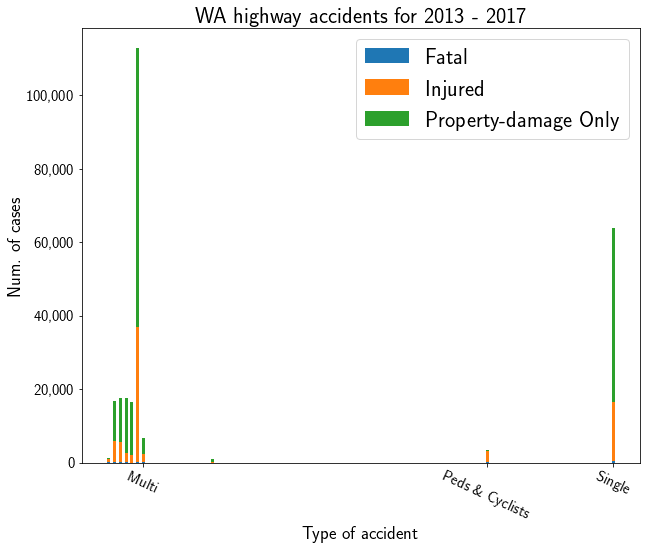

In [10]:
big_df = acc_by_type[2013] + acc_by_type[2014] + acc_by_type[2015] + acc_by_type[2016] + acc_by_type[2017]

fig, ax = plt.subplots(figsize=(10,8))

p1 = plt.bar(big_df.index, list(big_df.FAT), width)
p2 = plt.bar(big_df.index, list(big_df.INJ), width, bottom=list(big_df.FAT))
p3 = plt.bar(big_df.index, list(big_df.PDO), width, bottom=list(big_df.FAT+big_df.INJ))

plt.xticks([17, 77, 99], [r'Multi', r'Peds \& Cyclists', r'Single'],rotation=-25)
# big_df.index: [11, 12, 13, 14, 15, 16, 17, 29, 77, 99]


ax.set_xlabel(r'Type of accident', fontsize=18)
ax.set_ylabel(r'Num. of cases', fontsize=18)
ax.tick_params(labelsize=15)
plt.title(r'WA highway accidents for 2013 - 2017', fontsize=22)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend((p1[0], p2[0], p3[0]), ('Fatal', 'Injured', 'Property-damage Only'), fontsize=22)
plt.show()

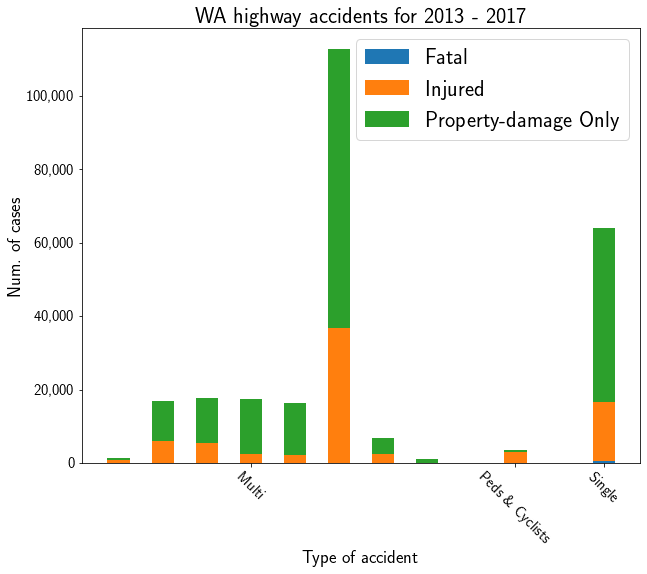

In [11]:
big_df = acc_by_type[2013] + acc_by_type[2014] + acc_by_type[2015] + acc_by_type[2016] + acc_by_type[2017]

fig, ax = plt.subplots(figsize=(10,8))

p1 = plt.bar([11, 12, 13, 14, 15, 16, 17, 18, 20, 22], list(big_df.FAT), width)
p2 = plt.bar([11, 12, 13, 14, 15, 16, 17, 18, 20, 22], list(big_df.INJ), width, bottom=list(big_df.FAT))
p3 = plt.bar([11, 12, 13, 14, 15, 16, 17, 18, 20, 22], list(big_df.PDO), width, bottom=list(big_df.FAT+big_df.INJ))

plt.xticks([14,20,22], [r'Multi', r'Peds \& Cyclists', r'Single'], rotation=-45)
# big_df.index: [11, 12, 13, 14, 15, 16, 17, 29, 77, 99]


ax.set_xlabel(r'Type of accident', fontsize=18)
ax.set_ylabel(r'Num. of cases', fontsize=18)
ax.tick_params(labelsize=15)
plt.title(r'WA highway accidents for 2013 - 2017', fontsize=22)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend((p1[0], p2[0], p3[0]), ('Fatal', 'Injured', 'Property-damage Only'), fontsize=22, loc='best')
plt.show()

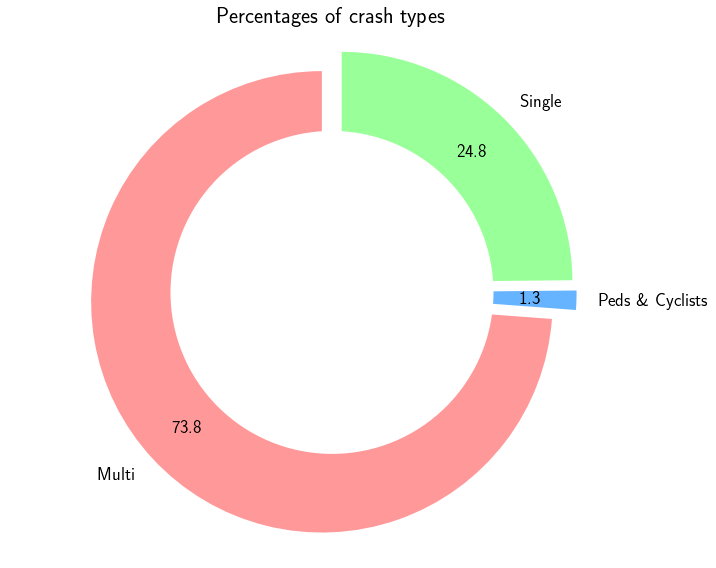

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

labels = [r'Multi', r'Peds \& Cyclists', r'Single']
sizes = [big_df[big_df.index.isin([11,12,13,14,15,16,17, 29])].cnt.sum(), 
         big_df[big_df.index.isin([77])].cnt,
        big_df[big_df.index.isin([99])].cnt]
#colors
colors = ['#ff9999','#66b3ff','#99ff99']

#explsion
explode = (0.06, 0.06, 0.06)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.8, explode = explode, textprops={'fontsize': 18})

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
ax.set_title(r'Percentages of crash types', fontsize=22)
plt.tight_layout()
plt.show()

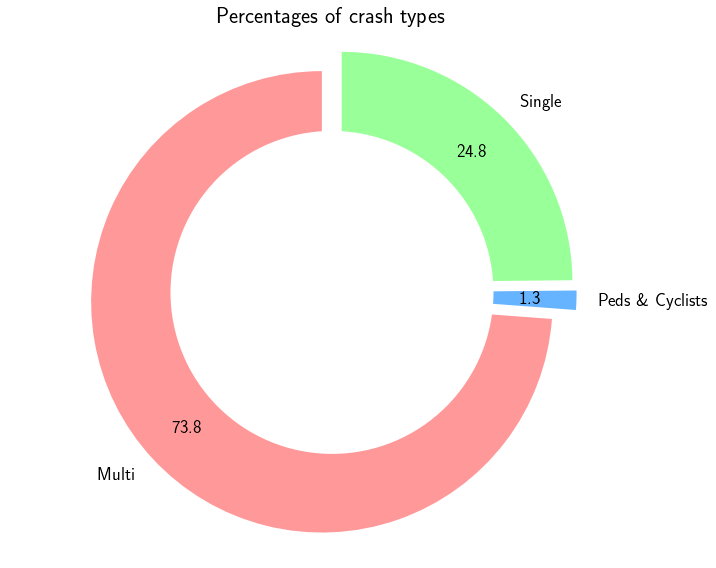

In [13]:
fig

#### Zoom in on the bars for multi-vehicle

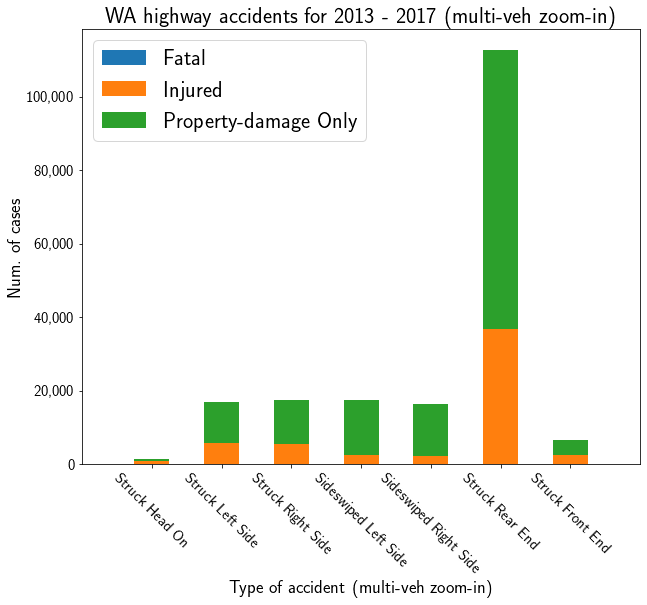

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

p1 = plt.bar(big_df.index, list(big_df.FAT), width)
p2 = plt.bar(big_df.index, list(big_df.INJ), width, bottom=list(big_df.FAT))
p3 = plt.bar(big_df.index, list(big_df.PDO), width, bottom=list(big_df.FAT+big_df.INJ))
plt.xticks(big_df.index, acc_type_list,rotation=-45)
plt.xlim(10,18)
# plt.ylim(0,20000)
ax.set_xlabel(r'Type of accident (multi-veh zoom-in)', fontsize=18)
ax.set_ylabel(r'Num. of cases', fontsize=18)
ax.tick_params(labelsize=15)
plt.title(r'WA highway accidents for 2013 - 2017 (multi-veh zoom-in)', fontsize=22)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.legend((p1[0], p2[0], p3[0]), ('Fatal', 'Injured', 'Property-damage Only'), fontsize=22)
plt.show()

### We can conclude from the plots:
+ Single vehicle accidents are a significant group, among the three;
+ Rear-end strikes dominate the multi-vehicle accidents;

### Break down the single-vehicle accidents
+ Why and how are people getting themselves into trouble?
+ Other parties, besides the vehicles, are lake, ditches, trains, self-caught fires in single-vehicle accidents;
+ These accidents only involve **half or even less** human factors as in multi-vehicle or vehicle-peds/ cyclists accidents;
+ This reduces uncertainty for modelling;

#### What are the types and how many are there?

In [15]:
crash = read_files(".././hsis-csv", 'acc')

combine_map = {
    
    71:77,# Peds and cyclist
    72:77,
    73:77,
    74:77,
    75:77,
    76:77

}

acc_by_type = {}
for year in range(2013, 2018):
    df = crash[year]
    acc_by_type[year] = df.ACCTYPE.replace(combine_map).value_counts().sort_index().to_frame()
    acc_by_type[year].columns = ['cnt']
    df = df[['ACCTYPE', 'REPORT']]
    df.ACCTYPE = df.ACCTYPE.replace(combine_map)
    acc_by_type[year] = acc_by_type[year].merge(
        df.groupby(['ACCTYPE', 'REPORT']).size().unstack().fillna(0).astype(int),
        left_index=True, right_index=True)
    columns = ['cnt', 'PDO', 'INJ', 'FAT']
    acc_by_type[year].columns = columns

In [16]:
acc_type_list = [
    r'Strikes Animal or Bird', r'Strikes Appurtenance', r'Strikes Other Object', r'Strikes or Was Struck by Working Object', 
    r'Strikes Railroad Train', r'Was Struck by Railroad Train', r'Vehicle Overturned', r'Non-Collision Fire', 
    r'Ran into Roadway Ditch', r'Ran into River, Lake, etc.', r'Ran over Embankment – No Guardrail Present', r'Peds \& Cyclists',
    r'Pushed Vehicle Struck by Pushing Vehicle', r'Jackknife Trailer', r'Other'
]
acc_type_index_list = [32, 33, 34, 35, 40, 41, 50, 54, 60, 61, 62, 77, 88, 98, 99]
width = 0.5

fat = [acc_by_type[year].FAT for year in range(2013, 2018)]
inj = [acc_by_type[year].INJ for year in range(2013, 2018)]
pdo = [acc_by_type[year].PDO for year in range(2013, 2018)]


In [17]:
for item in acc_type_index_list:
    for df in fat:
        if item not in df.index:
            df.at[item] = 0
    for df in inj:
        if item not in df.index:
            df.at[item] = 0
    for df in pdo:
        if item not in df.index:
            df.at[item] = 0

#### single vehicle accidents sub-categories into two histogram

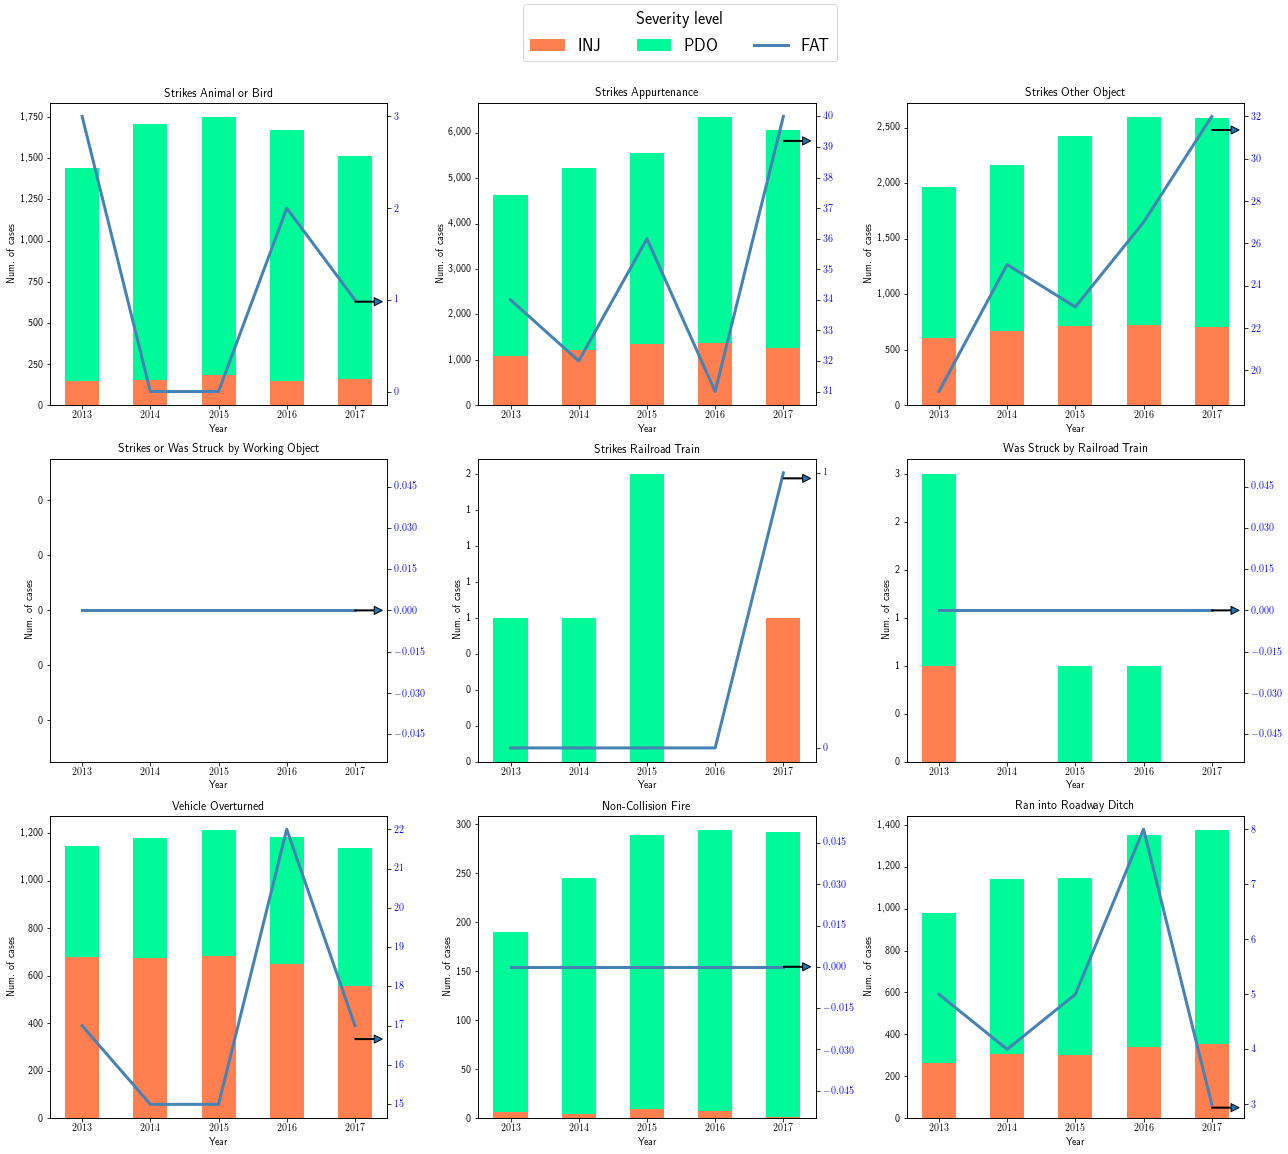

In [18]:
fig1, axes = plt.subplots(3,3, figsize=(18,15))

nyear = 5
t = range(2013, 2013 + nyear)
for ind in range(8):
    s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    ax1, _ = two_scales(axes[ind//3][ind%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
    ax1.set_title('{}'.format(acc_type_list[ind]))

ind += 1
s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
ax1, _ = two_scales_with_legend(axes[ind//3][ind%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
ax1.set_title('{}'.format(acc_type_list[ind]))

fig1.legend(
           # loc="upper center",   # Position of legend
           borderaxespad=0.3,    # Small spacing around legend box
           ncol=4,
           bbox_to_anchor=(0.65,1.07), 
           title="Severity level",  # Title for the legend
           fontsize="xx-large",title_fontsize="xx-large"
           )

plt.tight_layout()
plt.show()

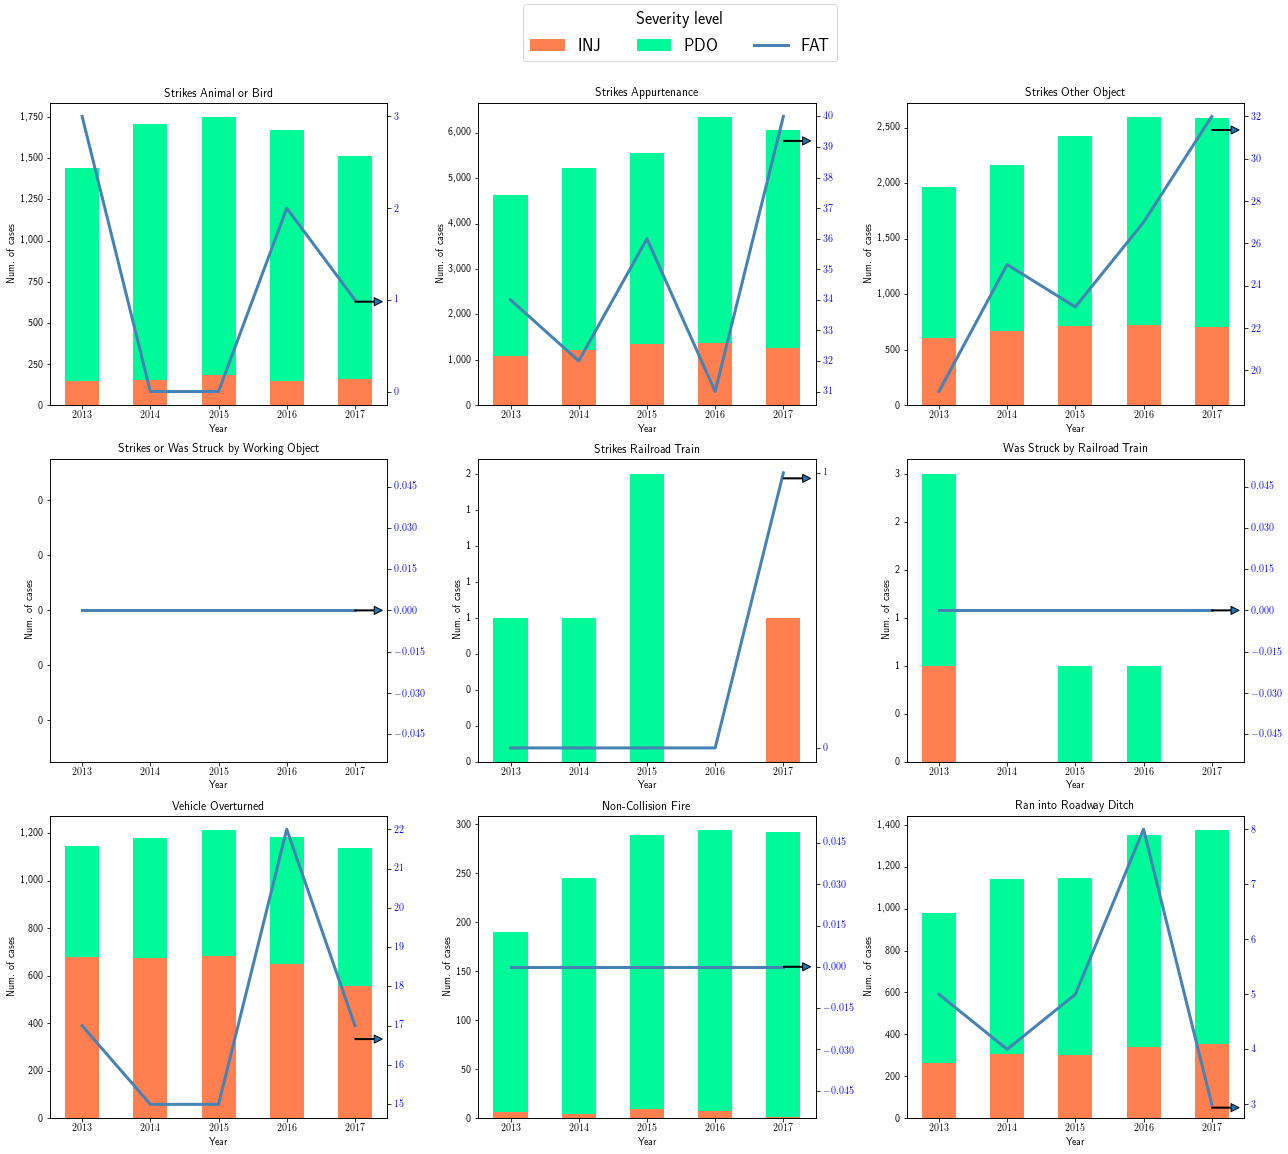

In [19]:
fig1

**Weird**<br>
the scroll does not work with the big graph, but works with two sub-plots

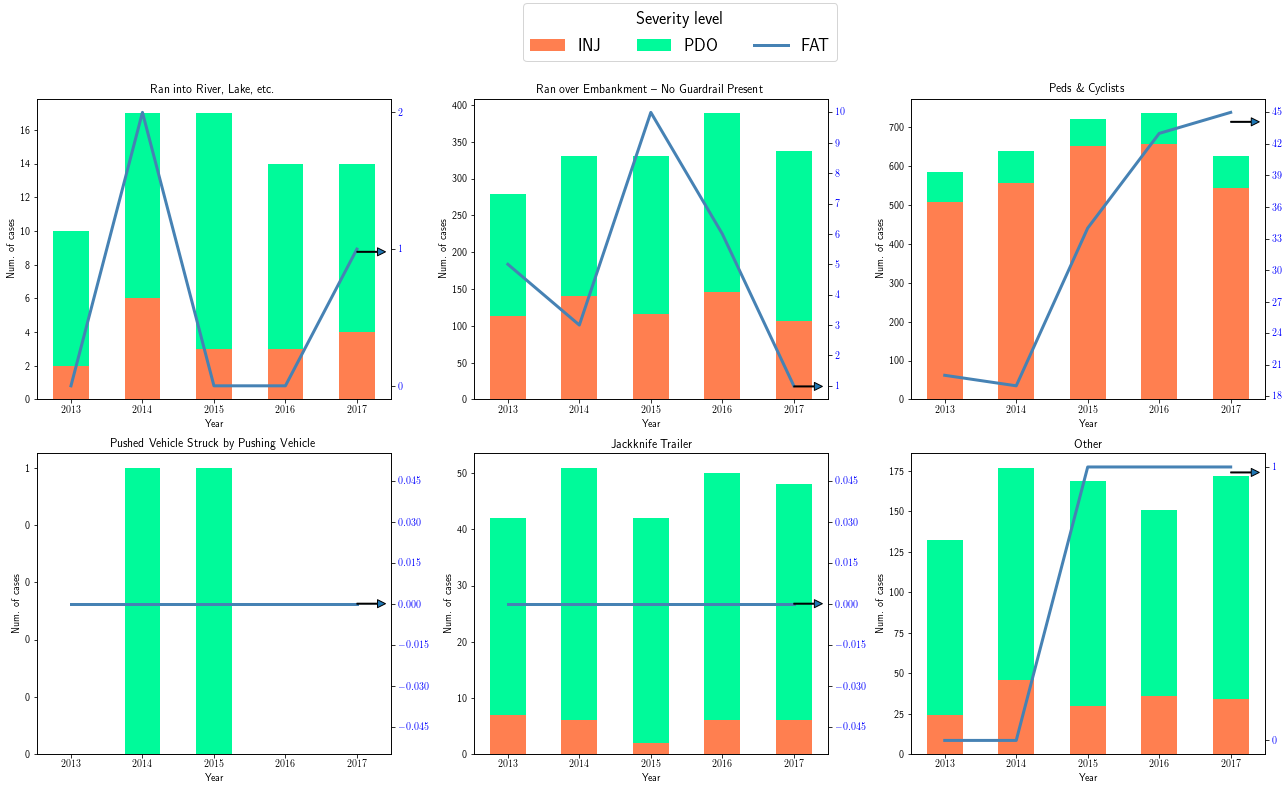

In [20]:
fig2, axes = plt.subplots(2,3, figsize=(18,10))

nyear = 5
t = range(2013, 2013 + nyear)
for ind in range(9, len(acc_type_list) - 1):
    s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    ax1, _ = two_scales(axes[(ind-9)//3][(ind-9)%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
    ax1.set_title('{}'.format(acc_type_list[ind]))

ind += 1
s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
ax1, _ = two_scales_with_legend(axes[(ind-9)//3][(ind-9)%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
ax1.set_title('{}'.format(acc_type_list[ind]))

fig2.legend(
           # loc="upper center",   # Position of legend
           borderaxespad=0.3,    # Small spacing around legend box
           ncol=4,
           bbox_to_anchor=(0.65,1.1), 
           title="Severity level",  # Title for the legend
           fontsize="xx-large",title_fontsize="xx-large"
           )

plt.tight_layout()
plt.show()

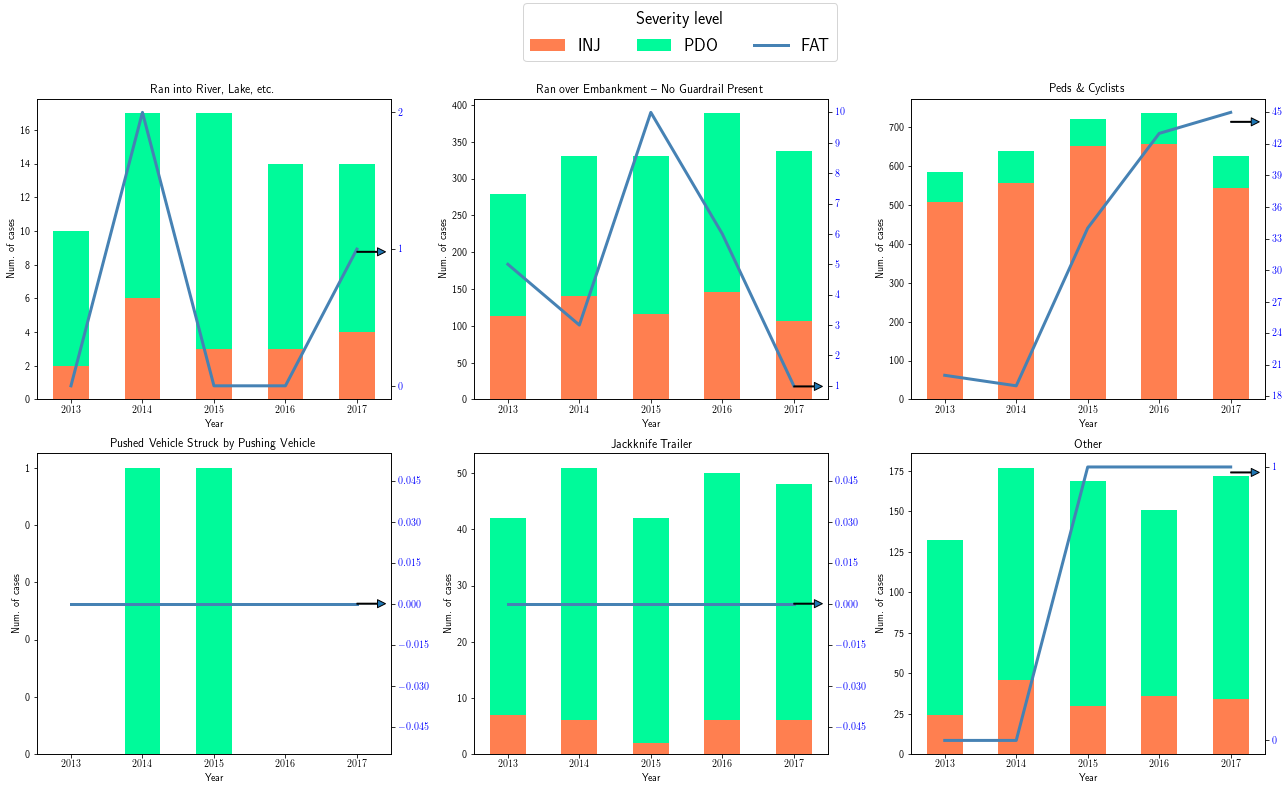

In [21]:
fig2

#### combined for single-veh 

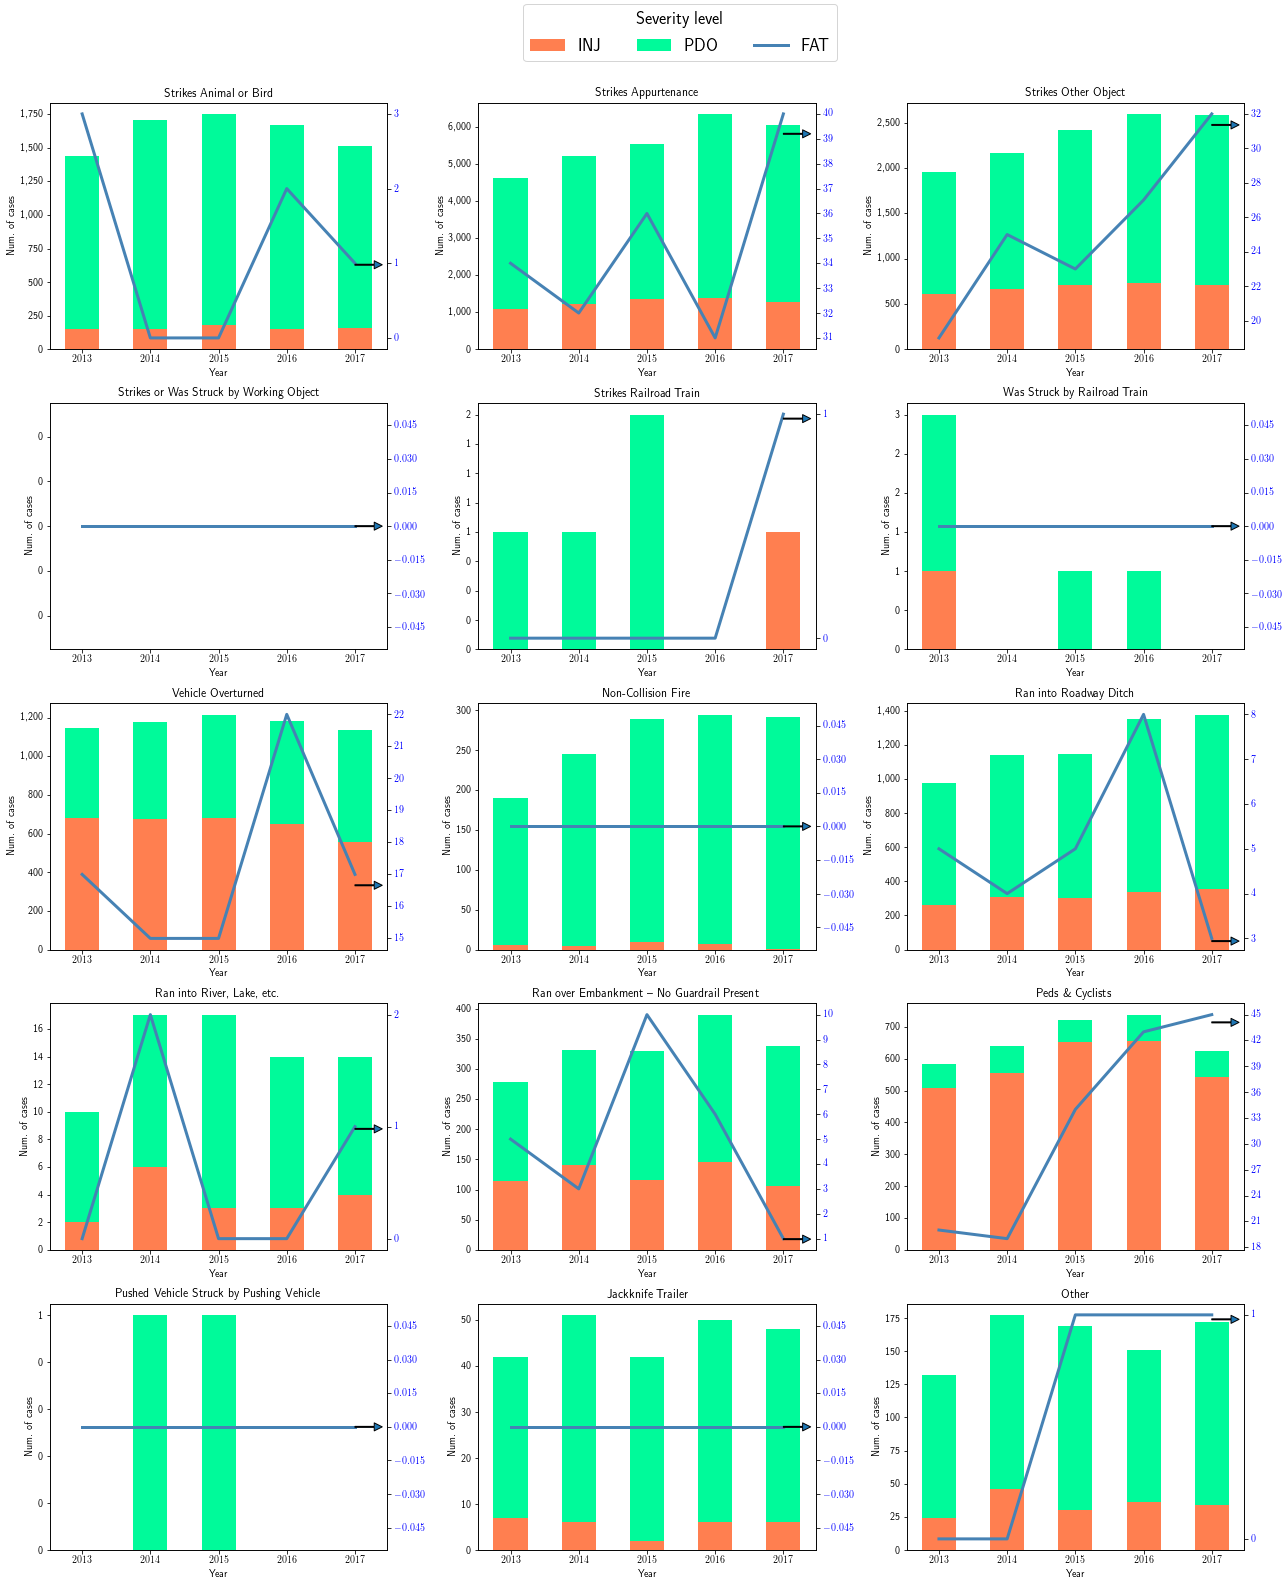

In [22]:
fig1, axes = plt.subplots(5,3, figsize=(18,21))

nyear = 5
t = range(2013, 2013 + nyear)
for ind in range(len(acc_type_list) - 1):
    s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
    ax1, _ = two_scales(axes[ind//3][ind%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
    ax1.set_title('{}'.format(acc_type_list[ind]))

ind += 1
s1 = [inj[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s2 = [pdo[year][acc_type_index_list[ind]] for year in range(0, nyear)]
s3 = [fat[year][acc_type_index_list[ind]] for year in range(0, nyear)]
ax1, _ = two_scales_with_legend(axes[ind//3][ind%3], t, s1, s2, s3, 'coral', 'mediumspringgreen', 'steelblue')
ax1.set_title('{}'.format(acc_type_list[ind]))

fig1.legend(
           # loc="upper center",   # Position of legend
           borderaxespad=0.3,    # Small spacing around legend box
           ncol=4,
           bbox_to_anchor=(0.65,1.05), 
           title="Severity level",  # Title for the legend
           fontsize="xx-large",title_fontsize="xx-large"
           )

plt.tight_layout()
plt.show()

### What we can tell from the plots?
+ Subgroups occur
    - High occurrence, high deaths: **Strikes Appurtenance**, **Strikes Other Object**, **Vehicles OVerturned**;
    - High occurrence, low deaths: **Strikes Animal or Bird**;
    - Low occurrence, high deaths: **Peds & Cyclists**;
    - Low occurrence, low deaths: others;

+ Different groups have different trends
    - Generally increasing;
    - Staying at the same level, fluctuating;

### We picked a type...
#### Strikes Appurtenance
#### It's coded as *type 33* in HSIS databases. As per [TRB](http://onlinepubs.trb.org/Onlinepubs/trr/1981/796/796.pdf) and [NCHRP](http://onlinepubs.trb.org/Onlinepubs/nchrp/nchrp_rpt_230.pdf):
Appurtenances covered by these procedures are<br>
+ longitudinal barriers such as bridge rails, guardrails, median barriers, transitions, and terminals;
+ crash cushions; 
+ breakaway or yielding supports for signs anci iuminaires. 

### Our model
+ Response variable: severity level (PDO/ INJ/ FAT);
+ Independent variable: 
    - Driver and vehicle: driver sex, driver age, intoxication, vehicle year, vehicle type;
    - Roadway: curvature, grade, segment length, road surface material, shoulder and median material and width;
    - Accident-specific: time, location, weather, light, road surface condition when accident took place;


| Variable | Description | possible values |
| :---: | :--- | :--- |
| <font color='red'>Weekday</font> | <font color='red'>Day of week when the accident occurred. <br>Further transformed into an indicator function.</font> | <font color='red'>1: Yes, 0: No</font> |
| <font color='red'>Peak-hour</font> | <font color='red'>If accident took place in peak hours,<br>i.e. 7-10am, 5-8pm</font> | <font color='red'>1: Yes, 0: No</font> |
| <font color='red'>Light</font> | <font color='red'>The type/level of light that existed<br>at the time of the crash</font> | <font color='red'>1: Daylight<br>2: Dawn<br>3: Dusk<br>4: Dark<br></font> |
| <font color='red'>Roadway surface<br>condition</font> | <font color='red'>The condition of the road surface<br>where the crash occurred</font> | <font color='red'>1:Dry<br>2:Wet<br>3:Snow/Slush<br>4:Ice<br>5:Other<br></font> |
| <font color='steelblue'>driver sex</font> | <font color='steelblue'>Driver sex</font> | <font color='steelblue'>1: Female<br>0: Male or unknown</font> |
| <font color='steelblue'>young driver</font> | <font color='steelblue'>If driver is younger than 25 years old</font> | <font color='steelblue'>1: Yes, 0: No</font> |
| <font color='steelblue'>old driver</font> | <font color='steelblue'>If driver is older than 65 years old</font> | <font color='steelblue'>1: Yes, 0: No</font> |
| <font color='steelblue'>drunk driver</font> | <font color='steelblue'>If driver had been drinking <br>and ability had been impaird</font> | <font color='steelblue'>1: Yes, 0: No</font> |
| <font color='LimeGreen'>Truck</font> | <font color='LimeGreen'>If the involved vehicle is truck</font> | <font color='LimeGreen'>1: Yes, 0: No</font> |
| <font color='LimeGreen'>Old car</font> | <font color='LimeGreen'>If the involved vehicle was <br>more than 15 years old at the time of crash</font> | <font color='LimeGreen'>1: Yes, 0: No</font> |
| <font color='DeepPink'>Rural/ Urban</font> | <font color='DeepPink'>Rural/ Urban indicator</font> | <font color='DeepPink'>R: Rural, U: Urban</font> |
| <font color='DeepPink'>Rd surface material</font> | <font color='DeepPink'>Surface material type</font> | <font color='DeepPink'>A: Asphalt<br>B: Bituminous<br>G: Gravel<br>O: Other<br>P: Portland Concrete Cem<br>S: Soil</font> |
| <font color='DeepPink'>lane width</font> | <font color='DeepPink'>Calculate lane width,<br> dividing total roadway width by num of lanes</font> | <font color='DeepPink'>continuous, in ft</font> |
| <font color='DeepPink'>Roadway width</font> | <font color='DeepPink'>Total roadway width for the roadway segment</font> | <font color='DeepPink'>continuous</font> |
| <font color='DeepPink'>degree of curvature</font> | <font color='DeepPink'>Degree of curvature for the curve,<br>calculated from curve radius</font> | <font color='DeepPink'>continuous, in ft</font> |
| <font color='DeepPink'>grade percentage</font> | <font color='DeepPink'>Percent grade for this roadway segment</font> | <font color='DeepPink'>continuous, in %</font> |
| <font color='DeepPink'>AADT</font> | <font color='DeepPink'>Calculated Annual average daily traffic (AADT)</font> | <font color='DeepPink'>integer</font> |
| <font color='DeepPink'>Truck percentage in traffic</font> | <font color='DeepPink'>Truck percentage for the roadway segment</font> | <font color='DeepPink'>continuous, in %</font> |
| <font color='DeepPink'>mvmt</font> | <font color='DeepPink'>Million vehicle miles traveled on road segment.</font> | <font color='DeepPink'>continuous, in veh-mile</font> |

## Data manipulation

### Initial steps
+ Summarize and regroup categorical variables;
+ Select possibly relevant variables from a original long list and drop those with too many missing values;

### Balance dataset
Two-ends balance with middle (add a percentage plot & table).

+ **Property damage only (PDO)** -> **Injury (INJ)**: Random sampling;
+ **Fatality (FAT)** -> **Injury (INJ)**: SMOTE Algorithm (oversampling by generating synthetic data);

Balanced dataset has size $$n_{\textrm{INJ}}\times3=4843\times3=14,529$$

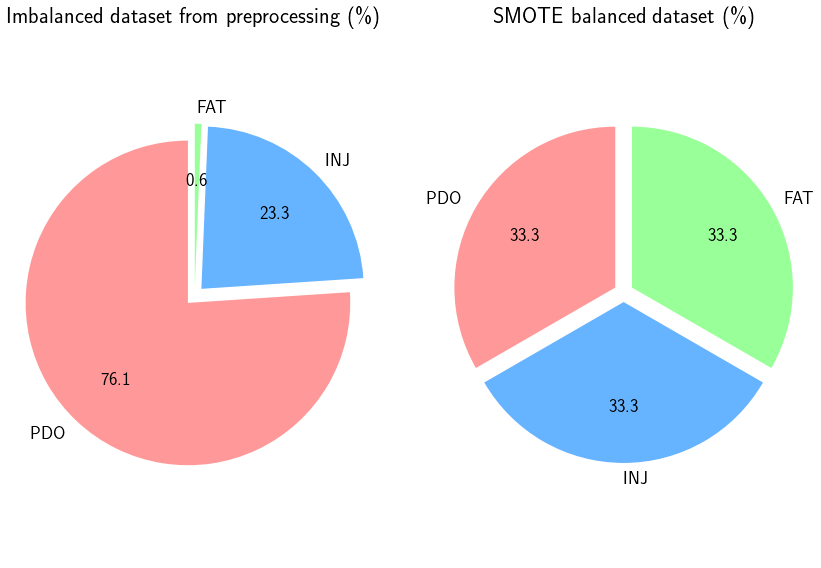

In [23]:
# before SMOTE [15809, 4843, 135]
#  df = pd.read_csv('.././merged/final_type_correct.csv')
# df.REPORT.value_counts()

# before SMOTE [4843, 4843, 4843]
#df = pd.read_csv('.././merged/final_smote.csv')
# df.REPORT.value_counts()
fig, ax = plt.subplots(1,2, figsize=(12,8))

#colors
colors = ['#ff9999','#66b3ff','#99ff99']

#explsion
explode = (0.06, 0.06, 0.06)

labels = [r'PDO', r'INJ', r'FAT']
sizes = [[15809, 4843, 135], [4843, 4843, 4843]]
titles = [r'Imbalanced dataset from preprocessing (\%)', r'SMOTE balanced dataset (\%)']
for i in range(2):
    
    ax[i].pie(sizes[i], colors = colors, labels=labels, autopct='%1.1f%%', 
        startangle=90, pctdistance=0.65, explode = explode, textprops={'fontsize': 18})
    
    centre_circle = plt.Circle((0,0),0.70,fc='white')
#     fig = plt.gcf()
    
#     fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
    ax[i].axis('equal') 
    ax[i].set_title(titles[i], fontsize=22)
    
plt.tight_layout()
plt.show()

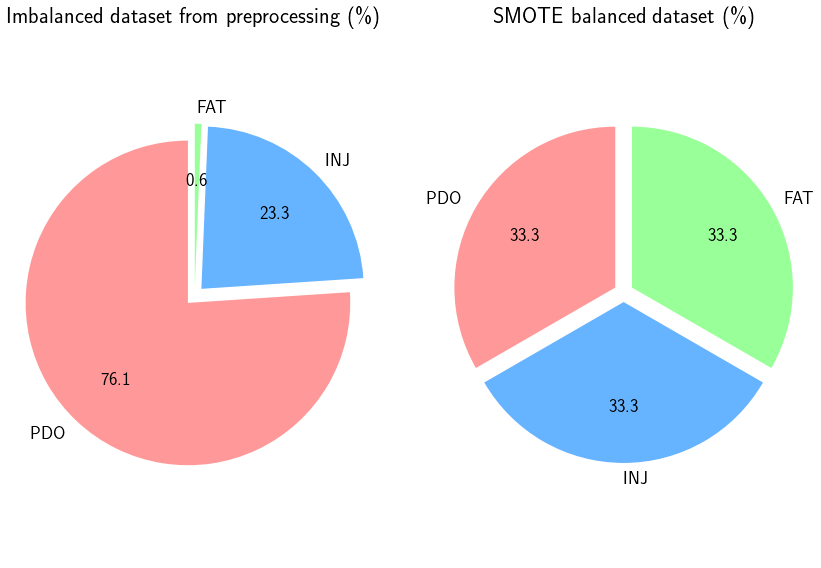

In [24]:
fig

#### Dataset fed into models
See the first 5 observations to have a general idea.

In [35]:
df_pre = pd.read_csv('.././merged/final_smote.csv')
df_pre = df_pre.drop(columns=['MEDWID', 'LSHLDWID', 'LSHL_WD2', 'RSHLDWID', 'RSHL_WD2', ])

In [36]:
df_pre.columns = ['Weekday', 'Roadway Surface Condition', 'Light',
                  'Weather', 'Rural/Urban', 'Rd Surface Material',
                  'Func Class', 'driver sex', 'young driver', 'old driver',
                  'drunk driver', 'Truck', 'Old car', 'Peak-hour',
                  'Lane width', 'Roadway width', 'degree of curvature',
                  'grade percentage', 'AADT', 'Truck percentage in traffic',
                  'mvmt', 'Severity'
                 ]
df_pre = df_pre[['Severity',
                      'driver sex', 'young driver', 'old driver', 'drunk driver',
                      'Truck', 'Old car',
                      'Rural/Urban', 'Lane width', 'Roadway width','degree of curvature','grade percentage',
                      'AADT', 'Truck percentage in traffic', 'mvmt',
                      'Weekday', 'Peak-hour', 'Light', 'Roadway Surface Condition', 'Rd Surface Material'
                     ]]

In [38]:
df_pre.shape

(14529, 20)

In [37]:
df_pre.head()

,Severity,driver sex,young driver,old driver,drunk driver,Truck,Old car,Rural/Urban,Lane width,Roadway width,degree of curvature,grade percentage,AADT,Truck percentage in traffic,mvmt,Weekday,Peak-hour,Light,Roadway Surface Condition,Rd Surface Material
0,1,0,1,0,1,0,1,U,12,96,0.75,0.08,172141.0,7.70,3.77,0,0,4,1,A
1,1,0,0,1,0,1,1,U,12,70,0.00,2.83,184453.0,0.00,0.67,1,0,1,2,P
2,1,1,1,0,0,0,0,R,12,72,0.00,1.55,56457.0,16.77,10.92,0,0,1,1,A
3,1,0,0,0,0,0,0,U,16,64,0.00,2.20,19480.0,5.46,0.50,1,1,1,1,A
4,1,0,0,0,0,0,0,U,12,48,0.00,0.93,71999.0,0.00,4.99,0,0,1,1,A


## Modeling and Results

#### Multinomial
+ Added interaction terms, e.g. **drunk \* young**;
+ Removed several variables that might be too micro: material and widths of shoulder and medium;
+ Response variable reference is **Fatality (FAT)**, category 3;

Accident severity level: (*PDO/INJ/FAT*) ~ 
+ *driver sex + young driver + old driver + drunk driver + drunk driver* \* *young driver* + <br>
+ *truck + old car* + <br>
+ *rural/ urban + lane width + roadway width + degree of curvature + grade percentage + AADT + truck percentage in traffic + mvmt* + <br>
+ *weekday + peak-hour + light conditinos + road surface condition* \* *roadway surface material*

#### Some of our hypotheses:

+ Driver sobriety (**drunk**): drivers who had been drinking and especially who had impaired ability are more likely to be involved in more severe crashes;
+ Vehicle type (**truck**): strikes on appurtenance by trucks must be a lot more severe than passenger vehicles, because trucks have greater momentums;
+ Light condition (**LIGHT**): more severe crashes are more likely to take place in darker conditions;
+ Rural/ Urban roads (**RURURB**): rural roads in general have worse protection, and thus are more likely to have more severe crashes;
+ Road surface condition (**RDSURF**): The more slippery it is, the more severe the accident is likely to be;
+ Interaction of **drunk** and **young driver** (**drunk \* young**): young drivers who had been drinking are red alerts for severe crashes. Lack of experience is magnified by impaired abilities;

#### Model results
AIC(multinomial) = 24,211

##### Driver
+ Female driver are more likely to be involved in less severe crashes;
+ *Young* drivers (< 25 years of age), compared to others, are more likely to see less severe crashes;
+ *Old* drivers (> 65 years of age), compared to others, are more likely to see less severe crashes;
+ That said, the people in the middle (25 < age < 65) are likely to see more severe crashes;
+ *Drunk* drivers are more likely to see more severe crahes, like fatal;
+ *Drunk* *young drivers* are more likely to see less severe crashes;

| Variables | Coefficients  | p-value  |
| ------------- |:-------------:| -----:|
| **driver sex** *Female*:1  | 1.303e+00 | < 2e-16 ***|
| **driver sex** *Female*:2  |  1.738e+00 |  < 2e-16 *** |
|**young driver** *True*:1         |    1.783e+00  |  < 2e-16 *** |
|**young driver** *True*:2         |    1.763e+00  |  < 2e-16 *** |
|**old driver** *True*:1           |    9.616e-01  | 2.89e-15 *** |
|**old driver** *True*:2           |    1.196e+00  |   < 2e-16 *** |
|<font color='red'>**drunk driver** *True*:1    |  <font color='red'>-6.914e-01| <font color='red'>2.52e-16 ***|  
|<font color='red'>**drunk driver** *True*:2     |  <font color='red'> -2.285e-01 | <font color='red'>0.003188 ** |
|<font color='red'>**young driver** *True* : **drunk** *True*:1   |   <font color='red'>2.514e+00  |<font color='red'> 1.05e-08 ***|
|<font color='red'>**young driver** *True* : **drunk** *True*:2  |   <font color='red'>2.609e+00  | <font color='red'>1.92e-09 ***|

##### Vehicle
+ *Trucks* are more likely to see more severe crashes;
+ *Old cars* tend to witness less severe crahes;

| Variables | Coefficients  | p-value  |
| ------------- |:-------------:| -----:|
|<font color='red'>**Truck** *True*:1 |    <font color='red'> -9.207e-01 |  <font color='red'> < 2e-16 *** |
|<font color='red'>**Truck** *True*:2    |     <font color='red'> -2.947e-01  | <font color='red'>0.000159 ***|
|**Old car** *True*:1    |       3.208e-01  | 1.39e-08 *** |
|**Old car** *True*:2    |       4.326e-01  | 6.05e-15 *** |

##### Road
+ *Urban* roads are more likely to have less severe crashes, or equivalently, rural roads are more dangerous;
+ The wider the lanes are, the more likely a crash would be less severe;
+ Ohter roadway features are not contributing much;

| Variables | Coefficients  | p-value  |
| ------------- |:-------------:| -----:|
|<font color='red'>**Rural/ Urban** *Urban*:1   |     <font color='red'> 9.073e-01 | <font color='red'> < 2e-16 *** |
|<font color='red'>**Rural/ Urban** *Urban*:2   |     <font color='red'> 7.809e-01 | <font color='red'> < 2e-16 *** |
|**Lane width**:1      |      1.006e-01  | 8.82e-09 *** |
|**Lane width**:2      |      1.206e-01  | 3.04e-12 *** |
|**Roadway width**:1     |      3.608e-04  | 0.869429     |
|**Roadway width**:2     |     -1.784e-03  | 0.411822     |
|**degree of curvature**:1     |      1.189e-02  | 0.025466 *   |
|**degree of curvature**:2     |      2.029e-02  | 3.03e-05 *** |
|**grade percentage**:1     |      6.779e-04  | 0.057607 .   |
|**grade percentage**:2     |      8.743e-04  | 0.014120 *   |
|**AADT**:1         |      2.301e-07  | 0.790135     |
|**AADT**:2         |      3.054e-06  | 0.000311 *** |
|**Truck percentage in traffic**:1      |      8.624e-03  | 0.049706 *   |
|**Truck percentage in traffic**:2      |      3.396e-03  | 0.435586     |
|**mvmt**:1         |      1.439e-02  | 0.000970 *** |
|**mvmt**:2         |      6.747e-03  | 0.122623     |

##### Environmental conditions
+ Crashes on *weekday* (vs. weekends) are more likely to be more severe;
+ Crashes in *peak-hour* are in general less severe;
+ Some light will help, as in *daylihgt*, *dawn*, *dusk*, crashes are more likely to be less severe, while *dark* is more likely to witness severe fatal crashes;
+ All road conditions, including *wet*, *snow* and *ice*, are likely to have less severe crashes. However, *Portland Concrete Cemt* when *wet* sees particularly less severe crashes, compared to fatal;

| Variables | Coefficients  | p-value  |
| ------------- |:-------------:| -----:|
| **Weekday** *True*:1 | -5.565e-01 | < 2e-16 ***|
| **Weekday** *True*:2 | -6.472e-01 |  < 2e-16 *** |
| **Peak-hour** *True*:1  | 1.371e+00      |   < 2e-16 *** |
| **Peak-hour** *True*:2  | 1.299e+00      |   < 2e-16 *** |
|<font color='red'>**Light** *Dawn*:1    |    <font color='red'>  3.698e+00  | <font color='red'> 3.90e-07 ***|
|<font color='red'>**Light** *Dawn*:2    |    <font color='red'>  3.717e+00  | <font color='red'> 3.32e-07 ***|
|<font color='red'>**Light** *Dusk*:1    |    <font color='red'>  3.586e+00  |<font color='red'>  3.92e-09 ***|
|<font color='red'>**Light** *Dusk*:2    |    <font color='red'>  3.464e+00  | <font color='red'> 1.21e-08 ***|
|<font color='red'>**Light** *Dark*:1    |    <font color='red'> -4.870e-01  | <font color='red'>  < 2e-16 ***|
|<font color='red'>**Light** *Dark*:2    |    <font color='red'> -5.184e-01  | <font color='red'>  < 2e-16 ***|
|<font color='red'>**Roadway Surface Condition** *Wet*:1 |   <font color='red'>   1.953e+00 |  <font color='red'>< 2e-16 ***|
|<font color='red'>**Roadway Surface Condition** *Wet*:2   |   <font color='red'>   1.714e+00 | <font color='red'> < 2e-16 ***|
|<font color='red'>**Roadway Surface Condition** *Snow/Slush*:1   |     <font color='red'> 6.662e+00  | <font color='red'>3.44e-11 ***|
|<font color='red'>**Roadway Surface Condition** *Snow/Slush*:2  |     <font color='red'> 5.901e+00  |<font color='red'> 4.67e-09 ***|
|<font color='red'>**Roadway Surface Condition** *Ice*:1    |   <font color='red'>    5.652e+00 | <font color='red'>3.38e-15 ***|
|<font color='red'>**Roadway Surface Condition** *Ice*:2   |  <font color='red'>    5.145e+00  | <font color='red'>8.79e-13 **|
|**Roadway Surface Condition** *Wet* : <br>**Rd Surface Material** *Portland Cem*:1 | 8.983e-01  | 2.28e-05 ***|
|**Roadway Surface Condition** *Wet* : <br>**Rd Surface Material** *Portland Cem*:2 | 8.824e-01  2| 3.15e-05 ***|

#### Did that validate our guesses?
+ Almost everything is what we expected. Except **the following two**;
+ Road surface at the crash scene is not very informative. It says *Wet*, *Snow/Slush* and *Ice* conditions are more likely to witness less severe crashes;
+ **Drunk \* young** interaction term is not warning us against the danger of drunk young driver;

+ Explanations:
    - ***Road surface condition*** appears weird: 
        * **road surface conditions** themselves are simply not enough. We are looking at the problem from too high a level that details are overlooked. Think of how cooking time contribute to the quality of dishes. If we have more soups in our menu, then running a general model will tell us the longer we cook the better. However, this does not hold across the entire dataset.
    - ***Drunk * young*** interaction: 
        * could be the *young drivers* effect offsettting the effect from *drunk* drivers. Remeber, even if young drivers are often associated with traffic accidents, they are not necessarily associated with severe accidents, e.g. fatal crashes. Being young is giving rise to the possibility of creating an accident, but not to that of a severe one.

##### Why?

+ Complex interactions:
     - Compared to more inclusive models, we know interactions are missing;
         * Diffrent road surface materials may have different behaviors under different conditions. It's very likely that when **wet** (instead of **standing water**), some materials produce better friction. This is what we observed for *Portland Concrete Cemt*;
+ Insufficient data:
    - Some important info is impossible to collect;
        * For example, speed of vehicle before crash is an important factor. Since we may acquire flow speed from sensors, how much faster the vehicle is travelling can largely impact the severity. However, it was almost impossible to collect such data;
    - When recorded as categorical, attributes lose the level of detail to be modeled by more complex link functions;
+ Data quality control:
    - In general the dataset is well maintained. However, some problems still exist. Variables can take values not specified in the guidebook, the most common being *10* often coded as *.* (period). Another problem is the coding of **vehicle type**, where the WA file is not explicitly writing out the codings. Yet another is absence of data for some variables: nothing returned even the guidebook says the variables are recorded.
    - Considering these issues, the quality of dataset can be further enhanced. Maybe that can answer some of our confusions from the multinomial modeling.

#### Ordinal
AIC(Ordinal) is way higher than **multinomial**'s. We focus on multinomial then.

#### prediction power
Is our model robust in predicting for unseen data?

In [ ]:
cm_smote = np.array([[1114, 98,  149],
       [ 320,  607,  435],
       [   298,    428,   632]])

In [ ]:
fig = plt.figure(figsize=(10,10))
# fig.set_size_inches(14, 12, forward=True)
# fig.align_labels()
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

cm = cm_smote
normalize = True
classes = ['PDO','INJ','FAT']

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 2.5)

plt.xticks([0,1,2], classes, fontsize=15)
plt.yticks([0,1,2], classes, fontsize=15)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=20
            )

# plt.tight_layout()
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.title('Confusion matrix of multinomial logistic modelling', fontsize=22)

plt.show()

In [ ]:
fig

##### Class_weight balancing

**LogisticRegression** from **sklearn.linear_model**<br>
Overall accuracy is 49.65%.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv('.././merged/final_type_correct.csv')
df = df.drop(columns=['FUNC_CLS'])
df_log = pd.get_dummies(df, columns=['WEEKDAY', 'RDSURF', 'LIGHT', 'RURURB', 'SURF_TYP'])

In [ ]:
y = df_log['REPORT']
X = df_log.drop(columns=['REPORT', 'ACCTYPE'])

msk = np.random.rand(len(df)) < 0.8
X_train = X[msk]
X_test = X[~msk]
y_train = y[msk]
y_test = y[~msk]

In [ ]:
clf = LogisticRegression(multi_class='multinomial',class_weight='balanced',
                         solver='newton-cg',penalty='none'
                        ).fit(X_train, y_train)
prediction = clf.predict(X_test)

In [ ]:
clf.score(X_train, y_train)

In [ ]:
cnf_matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

cnf_matrix = confusion_matrix(y_test, prediction)

fig = plt.figure(figsize=(10,10))
# fig.set_size_inches(14, 12, forward=True)
# fig.align_labels()
# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

cm = cnf_matrix
normalize = True
classes = ['PDO','INJ','FAT']

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
else:
    print('Confusion matrix, without normalization')

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 2.5)

plt.xticks([0,1,2], classes, fontsize=15)
plt.yticks([0,1,2], classes, fontsize=15)

fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=20
            )

# plt.tight_layout()
plt.ylabel('True label', fontsize=18)
plt.xlabel('Predicted label', fontsize=18)
plt.title('Confusion matrix of multinomial logistic modelling', fontsize=22)

plt.show()

In [ ]:
fig

## Conclusions
WA highway crashes are complex interplays of many variables. It's hard to model completely using multinomial logit regression. Among the available and applied variables, we summarize influences of some for each category into single sentences.
+ Driver:
    - Male, aged 25 - 65, drunk drivers are more likely to see more severe accidents;
+ Vehicle:
    - New vehicle and trucks are more likely to be involved in more severe crashes;
+ Roadway:
    - Rural roadway segments with narrower lanes and less traffic are more likely to witness more severe crashes;
+ Accident specific:
    - Weekdays at non peak-hour and especially when it's dark but not slippery on road surfaces are more likely to have more severe crashes;

### Limitations

+ Lack important variables (e.g. speed at crash);
+ Some potential underlying interaction effects not included;
+ Highly imbalanced dataset;

## Q&A
Thank you for your attention!